as a continuation of [feature_extraction_20200523](./feature_extraction_20200523.ipynb), this notebook examines in more detail certain models, regarding convergence of recurrent computations.

as a first step, it will focus on

1. models with a high number of recurrent cycles (5,6,7)
2. models with relatively smaller cycle-to-cycle differences. "cycle-to-cycle differences" can at least be defined in two ways. I hope two definitions lead to consistent results.
    1. taking response map as a whole (N x C x D x D) and check its relative change across iterations.
    2. taking response map of each of N images, and check **average** relative change across images.

In [1]:
from os.path import dirname, relpath, realpath, join, exists

import h5py

from numpy.linalg import norm
import numpy as np

from thesis_v2 import dir_dict
from thesis_v2.submission import utils
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200523_8k_feature_extraction_generator,
    script_keygen,
    keygen,
    gen_feature_extraction_global_vars
)
from json import dump, load
from os import remove
import pandas as pd

In [2]:
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
from thesis_v2.training.training_aux import load_training_results

In [3]:
def load_all():
    
    df_this = []
    
    batch_key='yuanyuan_8k_a/20200523'
    global_vars_for_feature_extraction = gen_feature_extraction_global_vars(key=batch_key)
    
    for idx, param_dict in enumerate(explored_models_20200523_8k_feature_extraction_generator()):
        
        cls = param_dict['rcnn_bl_cls']
        # only examine 5, 6, 7
        if cls <= 4:
            continue
        
        key_this = script_keygen(**param_dict)        
        h5file = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.hdf5')
        
        
        key_for_training_result = keygen(**{k: v for k, v in param_dict.items() if k not in {'scale', 'smoothness'}})
        result = load_training_results(key_for_training_result, return_model=False)
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        auxfile = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.json')
        assert exists(auxfile)
        auxfile2 = join(global_vars_for_feature_extraction['feature_file_dir'], key_this +'.per_image.json')
        assert exists(auxfile2)
                
        with open(auxfile, 'rt', encoding='utf-8') as f_aux:
            aux_obj = load(f_aux)
            
        with open(auxfile2, 'rt', encoding='utf-8') as f_aux2:
            aux_obj2 = load(f_aux2)
        
        if idx % 100 == 0:
            print(idx)
#             print(aux_obj)
#             print(aux_obj2)


        assert param_dict['kernel_size_l23'] == 3
        if len(param_dict) == 22:
            param_dict['train_keep'] = None
        assert len(param_dict) == 23
        
        assert param_dict['kernel_size_l1'] == 9
        assert param_dict['ff_1st_block']
        
        
        
        assert param_dict['split_seed'] == 'legacy'
        assert param_dict['pooling_ksize'] == 3
        assert param_dict['pooling_type'] == 'avg'
        assert not param_dict['bn_after_fc']
        assert param_dict['rcnn_bl_psize'] == 1
        assert param_dict['rcnn_bl_ptype'] is None
        assert param_dict['input_size'] == 50
        assert param_dict['rcnn_acc_type'] == 'cummean'

        if param_dict['train_keep'] is None:
            param_dict['train_keep'] = 5120

        index_base = {
            'train_keep': param_dict['train_keep'],
            'act_fn': param_dict['act_fn'],
            'loss_type': param_dict['loss_type'],
            'scale': float(param_dict['scale']),
            'smoothness': float(param_dict['smoothness']),
            'num_layer': param_dict['num_layer'],
            'out_channel': param_dict['out_channel'],
            # 4 to go.
            '1st_bn_before_act': param_dict['ff_1st_bn_before_act'],
            'rcnn_bl_cls': param_dict['rcnn_bl_cls'],

            'model_seed': param_dict['model_seed'],
        }
        
            
        df_this.append({**index_base, **{
            'acc_mode': 'instant',
            'diff_overall': aux_obj['test']['diff_bl_stack_instant'],
            'diff_per_image_mean': aux_obj2['test']['diff_bl_stack_instant']['mean'],
            'diff_per_image_std': aux_obj2['test']['diff_bl_stack_instant']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
        }})
        
        df_this.append({**index_base, **{
            'acc_mode': 'cummean',
            'diff_overall': aux_obj['test']['diff_bl_stack_cummean'],
            'diff_per_image_mean': aux_obj2['test']['diff_bl_stack_cummean']['mean'],
            'diff_per_image_std': aux_obj2['test']['diff_bl_stack_cummean']['std'],
            'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
            'h5file': h5file,
        }})
    
    index_keys = list(index_base.keys()) + ['acc_mode',]
    
    df_this = pd.DataFrame(
        data=df_this,
        columns=index_keys + ['diff_overall', 'diff_per_image_mean', 'diff_per_image_std', 'corr_test', 'h5file']
    ).set_index(keys=index_keys, verify_integrity=True)
    return df_this
df_all = load_all()

1200
1300
1400
1500
1600
1700
1800
1900
2000


In [4]:
df_all_cp = df_all.copy(deep=True)

In [5]:
df_all_cp['mean_diff_overall'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_overall']))
df_all_cp['mean_diff_per_image'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_per_image_mean']))
df_all_cp['mean_diff_overall_first4'] = df_all.apply(axis=1, func=lambda x: np.mean(x['diff_overall'][:4]))

In [6]:
from scipy.stats import pearsonr

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    assert x.shape == y.shape == (x.size,)
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('N', x.size)
    print('x mean', x.mean(), 'std', x.std())
    print('y mean', y.mean(), 'std', y.std())
#     print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
#     print('y top', y.max(), 'x top', x.max())

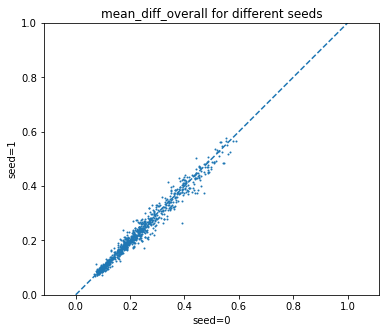

N 864
x mean 0.22961057125573495 std 0.11724714656934838
y mean 0.22743103858780542 std 0.11513645656119693
(0.9860099881499227, 0.0)


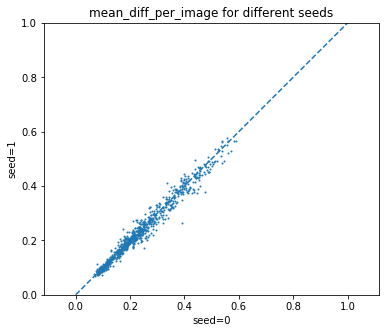

N 864
x mean 0.2297059555381171 std 0.1175209562056585
y mean 0.2276182522107345 std 0.11547396211933261
(0.9864505707233416, 0.0)


In [9]:
# almost the same.
def check_similarity_across_seeds():
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_overall'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_overall for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_per_image'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_per_image for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
check_similarity_across_seeds()

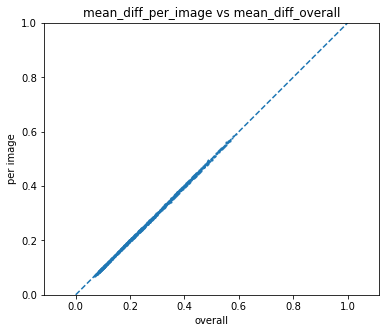

N 1728
x mean 0.22852080492177015 std 0.1162017043537829
y mean 0.22866210387442581 std 0.11650663141560001
(0.9998814600373054, 0.0)


In [10]:
# check consistency between mean_diff_overall and mean_diff_per_image

def check_consistency_between_diff_overall_and_per_image():
    
    val1 = df_all_cp['mean_diff_overall'].values
    val2 = df_all_cp['mean_diff_per_image'].values
    scatter(val1, val2, 'overall', 'per image', 'mean_diff_per_image vs mean_diff_overall')
    print(pearsonr(val1, val2))
    
# almost the same.
check_consistency_between_diff_overall_and_per_image()

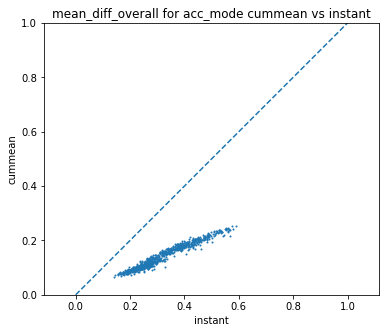

N 864
x mean 0.31623478261725174 std 0.09799155914530337
y mean 0.14080682722628862 std 0.04489813759381985
(0.9772972061512966, 0.0)


In [11]:
def check_consistency_between_instant_and_cummean():
    
    val1 = df_all_cp['mean_diff_overall'].xs('instant', level='acc_mode').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'instant', 'cummean', 'mean_diff_overall for acc_mode cummean vs instant')
    print(pearsonr(val1.values, val2.values))
    
# pretty consistent. let's use cummean for prettier results
check_consistency_between_instant_and_cummean()

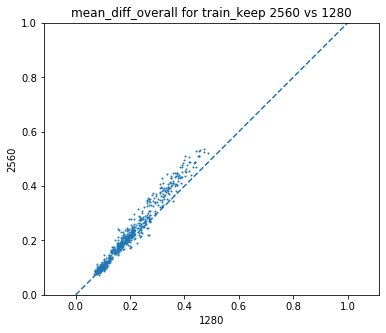

N 576
x mean 0.20532977792964732 std 0.09736963858388667
y mean 0.23064723555181882 std 0.1148169525080841
(0.9835739947362594, 0.0)


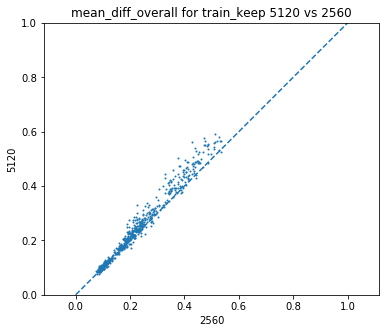

N 576
x mean 0.23064723555181882 std 0.1148169525080841
y mean 0.2495854012838444 std 0.12984092776509515
(0.9869952901891853, 0.0)


In [12]:
# check relationship to training size
def check_diff_overall_over_train_keep():
    
    val1 = df_all_cp['mean_diff_overall'].xs(1280, level='train_keep').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs(2560, level='train_keep').sort_index()
    val3 = df_all_cp['mean_diff_overall'].xs(5120, level='train_keep').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '1280', '2560', 'mean_diff_overall for train_keep 2560 vs 1280')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '2560', '5120', 'mean_diff_overall for train_keep 5120 vs 2560')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_train_keep()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

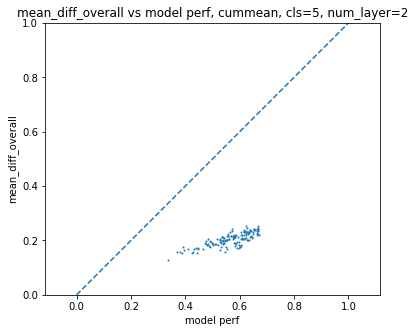

N 144
x mean 0.5661831530056222 std 0.07369466260983196
y mean 0.2046785202756938 std 0.02505058084027161
(0.7962713829449175, 8.420724944679902e-33)


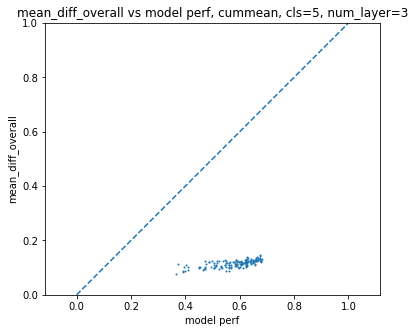

N 144
x mean 0.5781167678851149 std 0.076162403646722
y mean 0.11497343240383391 std 0.012996775586644069
(0.6816614380411687, 5.255677294049553e-21)


In [13]:
def check_relationship_between_diff_and_performance(*, num_layer, cls):
    val1 = df_all_cp['corr_test'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'model perf', 'mean_diff_overall', f'mean_diff_overall vs model perf, cummean, cls={cls}, num_layer={num_layer}')
    print(pearsonr(val1.values, val2.values))
    
check_relationship_between_diff_and_performance(num_layer=2, cls=5)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=5)

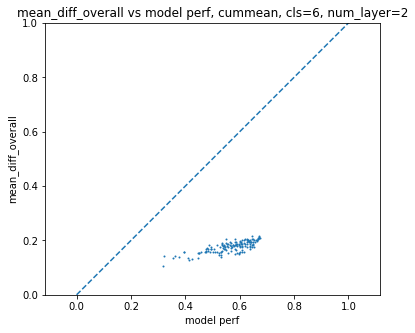

N 144
x mean 0.5659704430162767 std 0.07743248496948314
y mean 0.17725558954084086 std 0.020607586618243107
(0.7724522880039051, 8.631433944822295e-30)


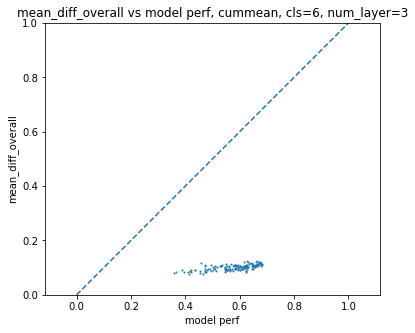

N 144
x mean 0.5770308270399309 std 0.07720237593885722
y mean 0.10123530494359632 std 0.010427129686703514
(0.6447448809322385, 2.7724423069237266e-18)


In [14]:
check_relationship_between_diff_and_performance(num_layer=2, cls=6)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=6)

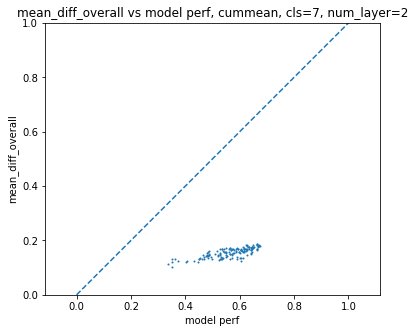

N 144
x mean 0.5654821739842547 std 0.07738153952367496
y mean 0.15576479385641437 std 0.017977855691875093
(0.7739678057588961, 5.695746624510432e-30)


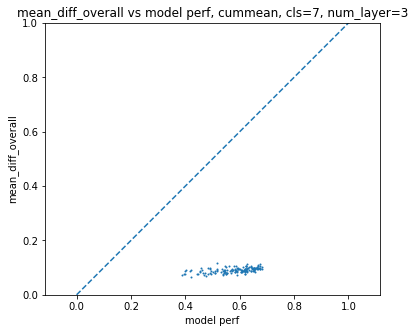

N 144
x mean 0.5781011550253319 std 0.07424714314259612
y mean 0.09093332233735257 std 0.009461789395775565
(0.5300581021667445, 8.369497945234078e-12)


In [15]:
check_relationship_between_diff_and_performance(num_layer=2, cls=7)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=7)

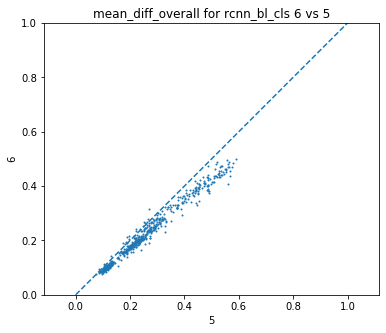

N 576
x mean 0.258605305317259 std 0.13019885587005
y mean 0.22584483817012777 std 0.11090446685334356
(0.989639175014608, 0.0)


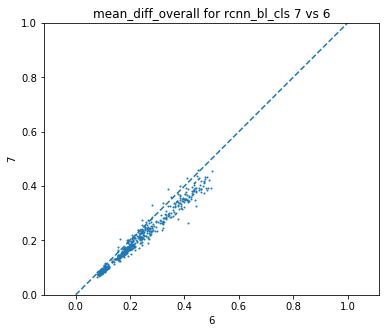

N 576
x mean 0.22584483817012777 std 0.11090446685334356
y mean 0.20111227127792383 std 0.09794641273507443
(0.9851029139747274, 0.0)


In [16]:
# relationship with cls
def check_diff_overall_over_cls(first4=False):
    field_to_check = 'mean_diff_overall' if not first4 else 'mean_diff_overall_first4'
    val1 = df_all_cp[field_to_check].xs(5, level='rcnn_bl_cls').sort_index()
    val2 = df_all_cp[field_to_check].xs(6, level='rcnn_bl_cls').sort_index()
    val3 = df_all_cp[field_to_check].xs(7, level='rcnn_bl_cls').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '5', '6', f'{field_to_check} for rcnn_bl_cls 6 vs 5')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '6', '7', f'{field_to_check} for rcnn_bl_cls 7 vs 6')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_cls()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

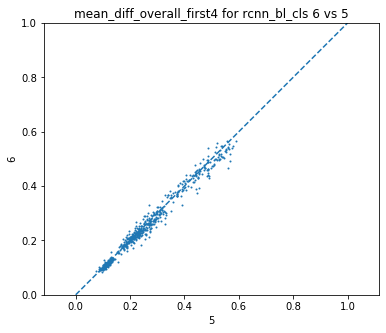

N 576
x mean 0.258605305317259 std 0.13019885587005
y mean 0.2550030098742961 std 0.1268367682519875
(0.990561688350267, 0.0)


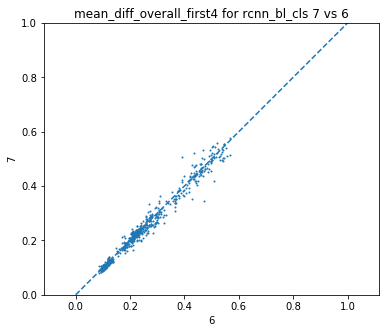

N 576
x mean 0.2550030098742961 std 0.1268367682519875
y mean 0.2528396332814332 std 0.12604878955268237
(0.9883210186395317, 0.0)


In [17]:
# always take time to drop. running more iterations won't make convergence quicker.
check_diff_overall_over_cls(True)

In [18]:
# so, let's study cls=7, cummean models

# which training size? study both 1280 and 5120

# maybe do a mean pooling first, to make vector shorter. also, the pooling version is what's actually used in fully connected layer.
from torch.nn.functional import avg_pool2d
import torch
def transform_data_all_epochs(tensor_list):
    for z in tensor_list:
        assert z.ndim == 4
#         print(z.shape)
    pooled_version = [avg_pool2d(torch.tensor(x), kernel_size=3).numpy() for x in tensor_list]
#     for zz in pooled_version:
# #         print(zz.shape)
        
    # then reshape . just concatenate them to do PCA/tSNE, etc.
    return [x.reshape(x.shape[0], -1) for x in pooled_version]


In [19]:
df_all_cp_to_study = df_all_cp.xs(0, level='model_seed').xs(7, level='rcnn_bl_cls').xs('cummean', level='acc_mode')

In [20]:
df_all_cp_to_study.iloc[0]

diff_overall                [0.2863568365573883, 0.150286003947258, 0.1018...
diff_per_image_mean         [0.2878949167765677, 0.1525291128223762, 0.102...
diff_per_image_std          [0.02502388094713124, 0.022255516563604482, 0....
corr_test                                                            0.371543
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.122599
mean_diff_per_image                                                  0.123321
mean_diff_overall_first4                                             0.154511
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, True), dtype: object

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
def show_data_for_one(data_this):
    # load h5file,
    # compute mean version
    # get pooled & reshaped version.
    cls = 7
    print(data_this)
    with h5py.File(data_this['h5file'], 'r') as f:
        g = f['test']
        tensor_list = [g[f'0.{x}'][()] for x in range(cls)]
    tensor_list_new = []
    for i in range(len(tensor_list)):
        tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
    tensor_list = tensor_list_new
    tensor_list = transform_data_all_epochs(tensor_list)
    
    # then concat them
    data_all_epochs = np.concatenate(tensor_list, axis=0)
    print(data_all_epochs.shape)
    # then do PCA
    
    # not useful, because only <15% of data explained in first two dims.
    
#     pca_obj = PCA(n_components=2, svd_solver='full')
#     data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_pca.shape)
#     print(pca_obj.explained_variance_ratio_)
    
    # try TSNE
    
    tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
    data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
    print(data_all_epochs_tsne.shape)
    return data_all_epochs_tsne

In [23]:
def show_data_for_one_pca(data_this, img_idx, cummean=True):
    # load h5file,
    # compute mean version
    # get pooled & reshaped version.
    cls = 7
#     print(data_this)
    with h5py.File(data_this['h5file'], 'r') as f:
        g = f['test']
        tensor_list = [g[f'0.{x}'][img_idx:img_idx+1,] for x in range(cls)]
        
    if cummean:
        tensor_list_new = []
        for i in range(len(tensor_list)):
            tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
        tensor_list = tensor_list_new
    tensor_list = transform_data_all_epochs(tensor_list)
    
    # then concat them
    data_all_epochs = np.concatenate(tensor_list, axis=0)
#     print(data_all_epochs.shape)
    # then do PCA
    
    # not useful, because only <15% of data explained in first two dims.
    
    pca_obj = PCA(n_components=2, svd_solver='full')
    data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_pca.shape)
#     print(pca_obj.explained_variance_ratio_)
    return {
        'pca': data_all_epochs_pca,
        'var_ratio': tuple(pca_obj.explained_variance_ratio_.tolist()),
    }
#     # try TSNE
    
#     tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
#     data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_tsne.shape)
#     return data_all_epochs_tsne

In [24]:
df_all_cp_to_study_sorted = df_all_cp_to_study.sort_values(by='corr_test', ascending=False)

In [25]:
# data_tsne = show_data_for_one(df_all_cp_to_study_sorted.iloc[0])

In [26]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

colors_to_use = cmap.colors

In [27]:
# 

In [28]:
def plot_25_graph_given_data(data_this, seed, cummean=True):
    print(data_this)
    plt.close('all')
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
    axes = axes.ravel()
    
    rng_state = np.random.RandomState(seed=seed)
    images_to_take =  rng_state.choice(1600, 25)
    assert len(axes) == len(images_to_take) == 25
    for img_idx, ax in zip(images_to_take, axes):
        # get pca
        pca_this = show_data_for_one_pca(data_this, img_idx, cummean)
        varratio = '{:.2f},{:.2f}'.format(pca_this['var_ratio'][0], pca_this['var_ratio'][1])
        ax.set_title(f"img {img_idx}, pca {varratio}")
        
        # plot.
        pca_xy = pca_this['pca']
        
        for idx_cls in range(pca_xy.shape[0]-1):
            xy = pca_xy[idx_cls]
            xydelta = pca_xy[idx_cls+1]-pca_xy[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1)
            
        ax.axis('equal')
        ax.set_xlim(pca_xy.min()-1, pca_xy.max()+1)
        ax.set_ylim(pca_xy.min()-1, pca_xy.max()+1)
    plt.show()

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


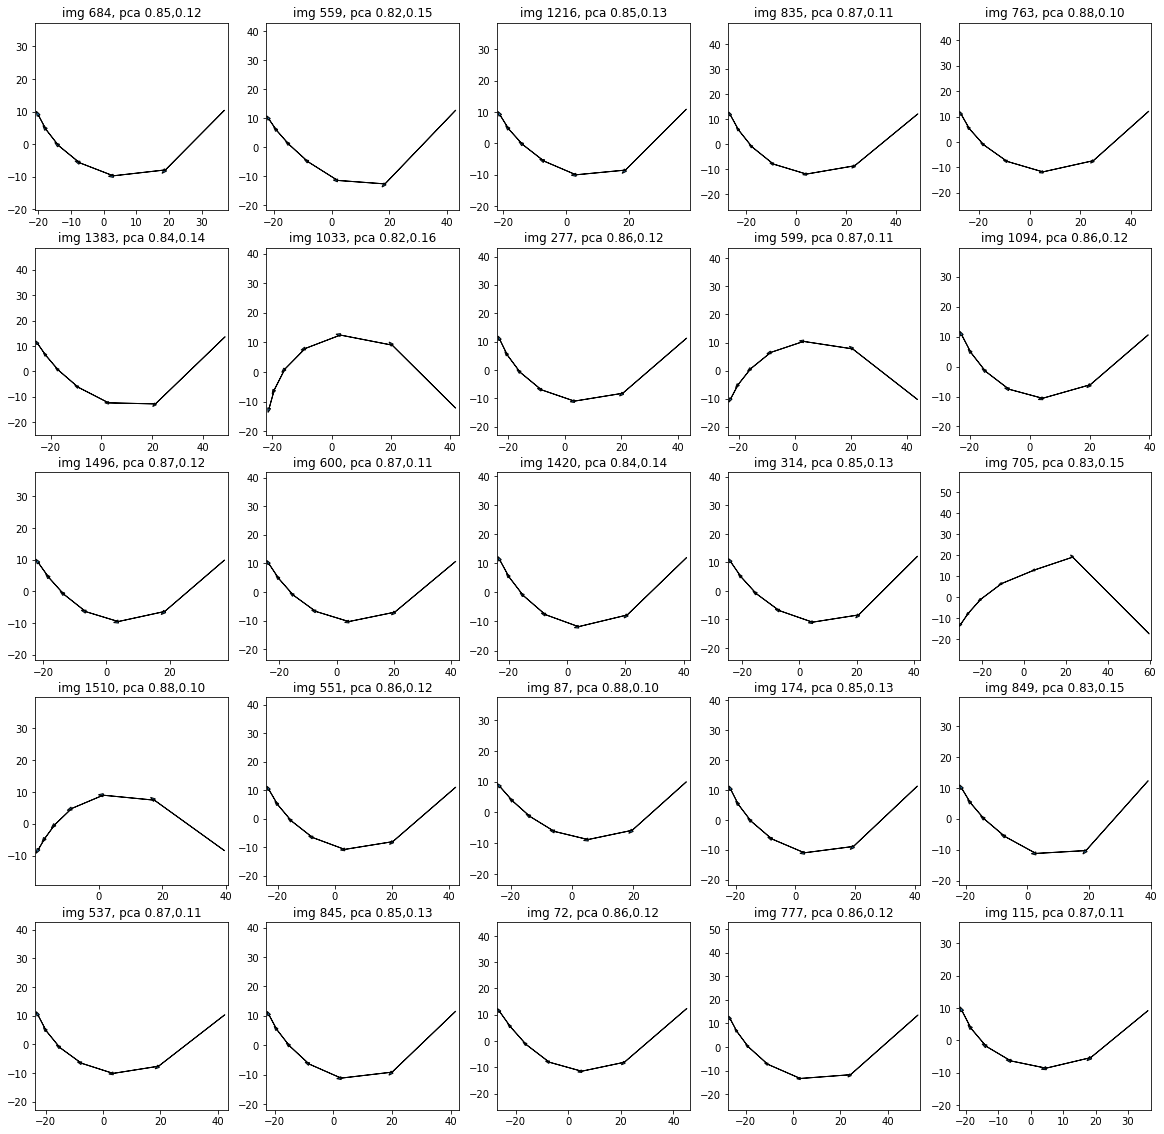

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


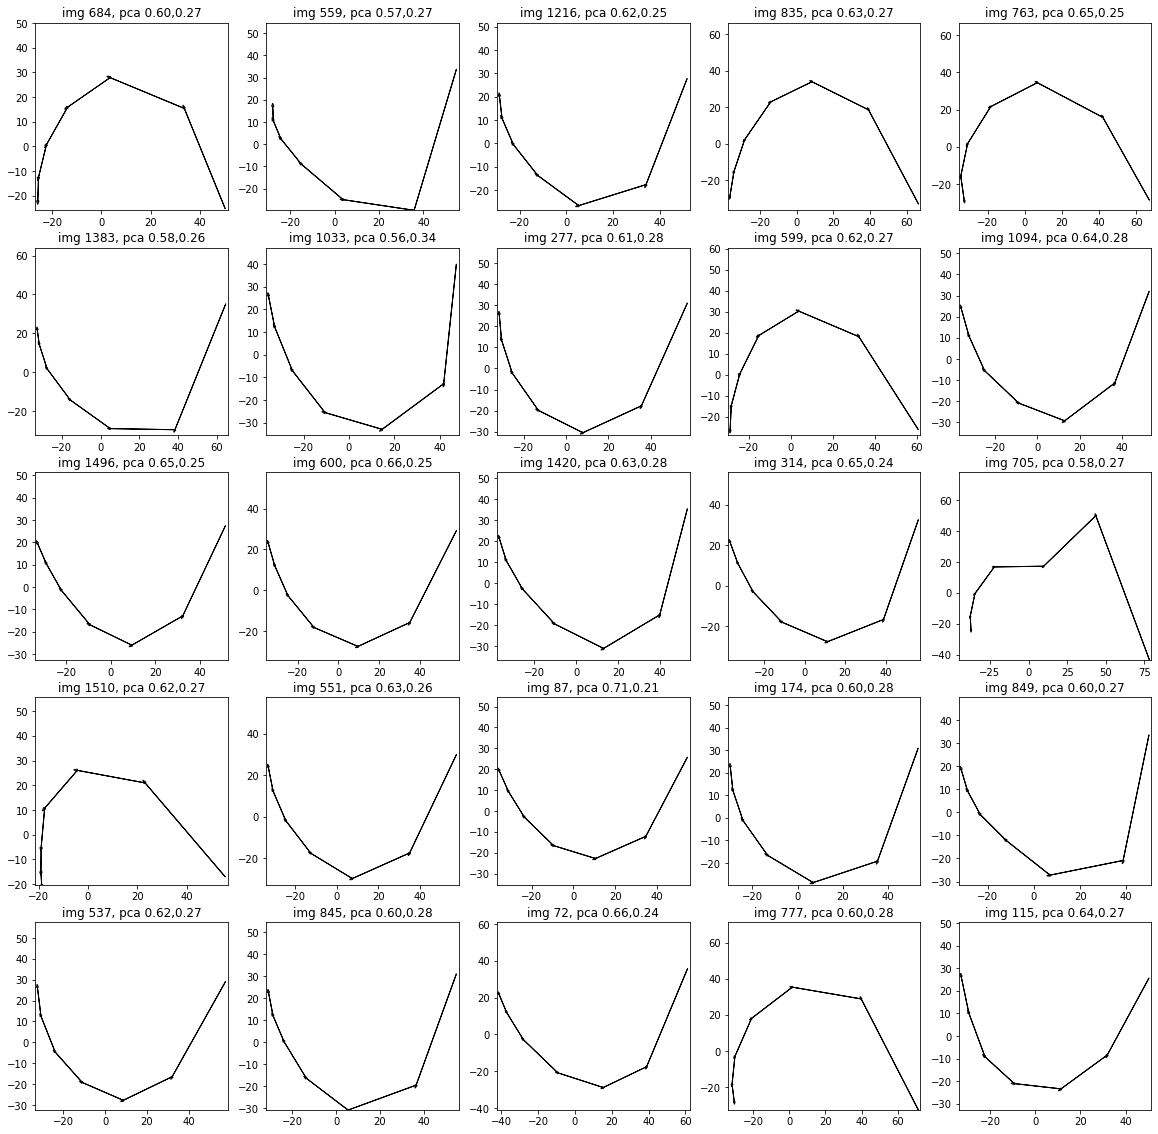

In [37]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 0)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 0, False)

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


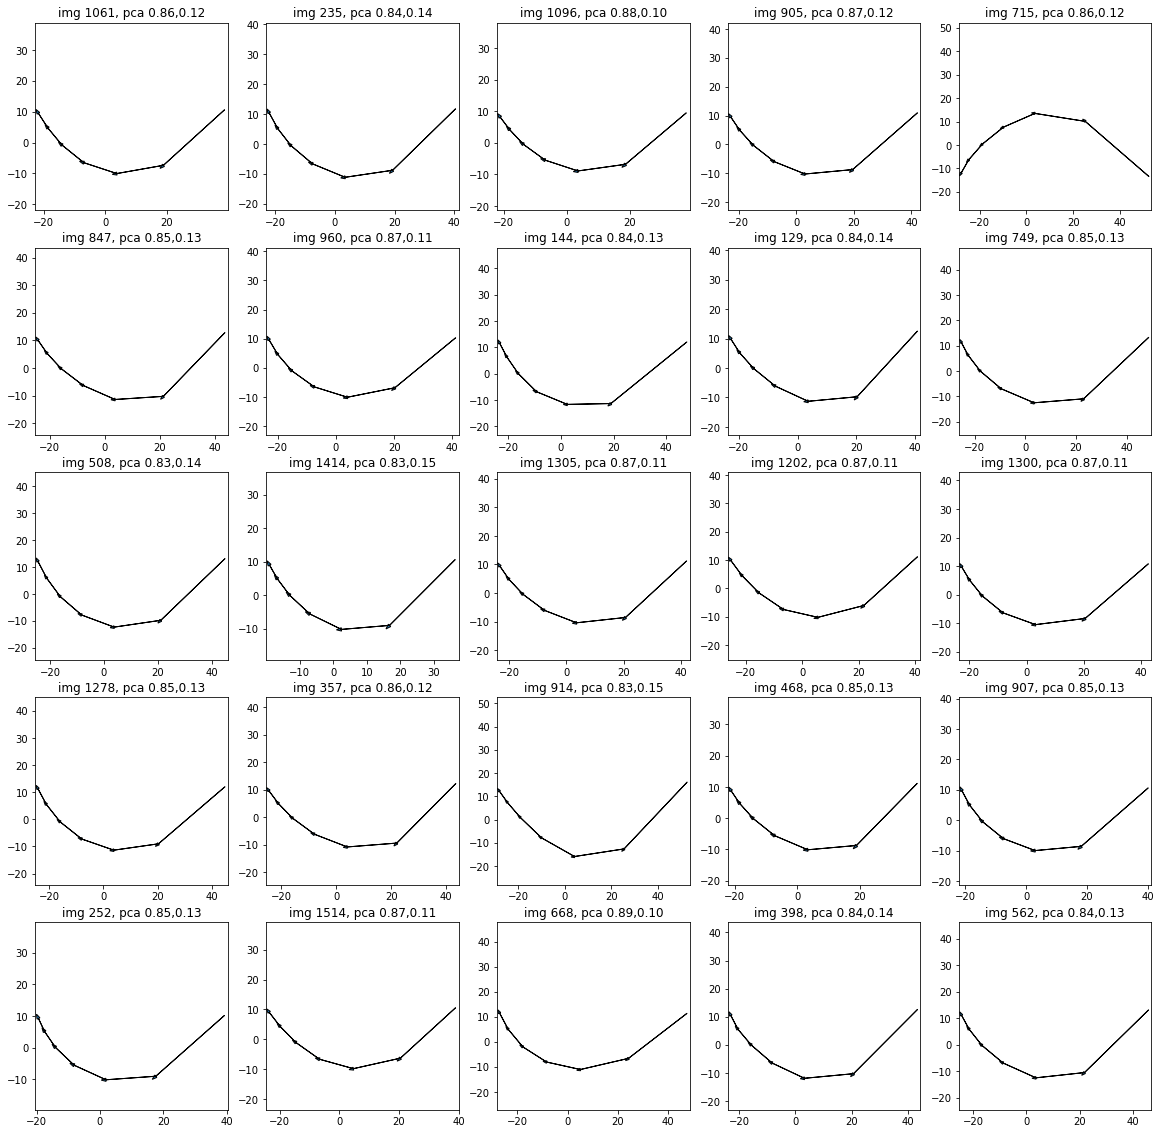

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


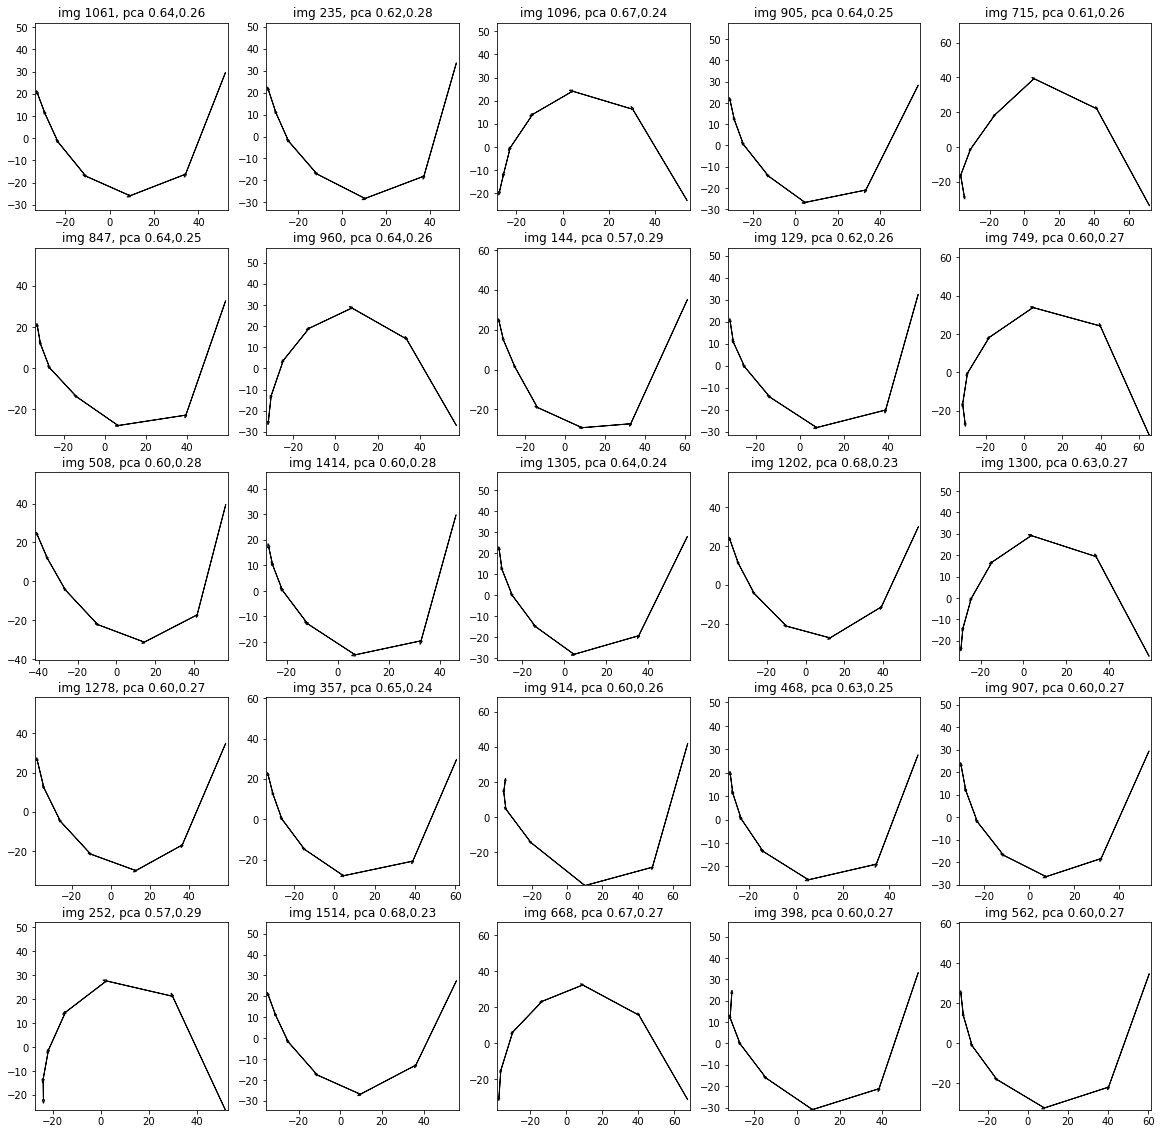

In [38]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 1)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 1, False)

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


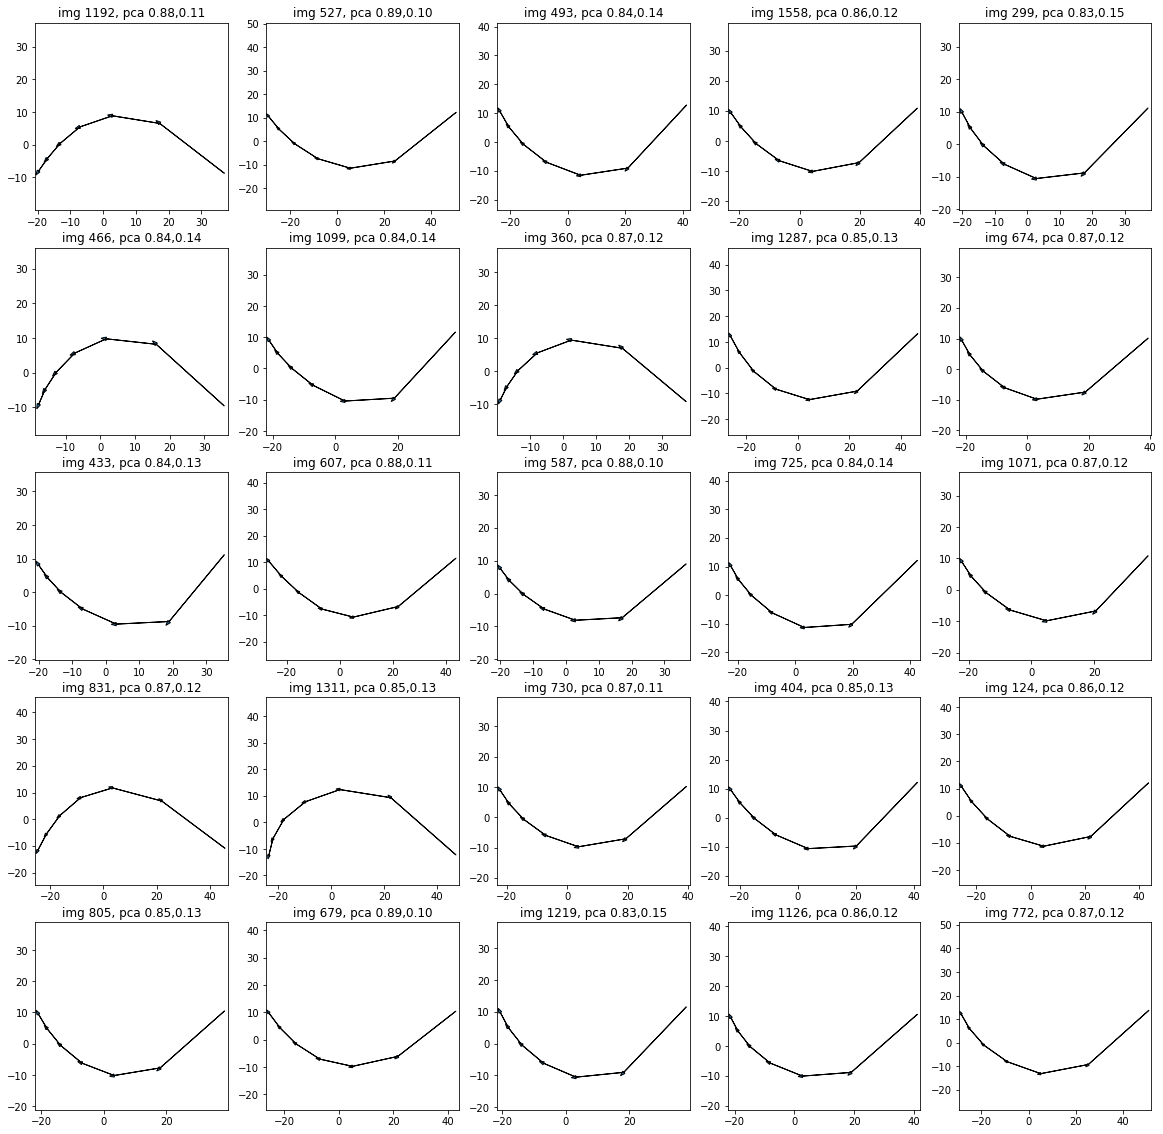

diff_overall                [0.22080190479755402, 0.1214217022061348, 0.08...
diff_per_image_mean         [0.21859183786436914, 0.1213121842360124, 0.08...
diff_per_image_std          [0.032985051430906735, 0.012789135509713424, 0...
corr_test                                                            0.682387
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                     0.09644
mean_diff_per_image                                                 0.0960986
mean_diff_overall_first4                                             0.121499
Name: (5120, softplus, poisson, 0.01, 5e-06, 3, 32, True), dtype: object


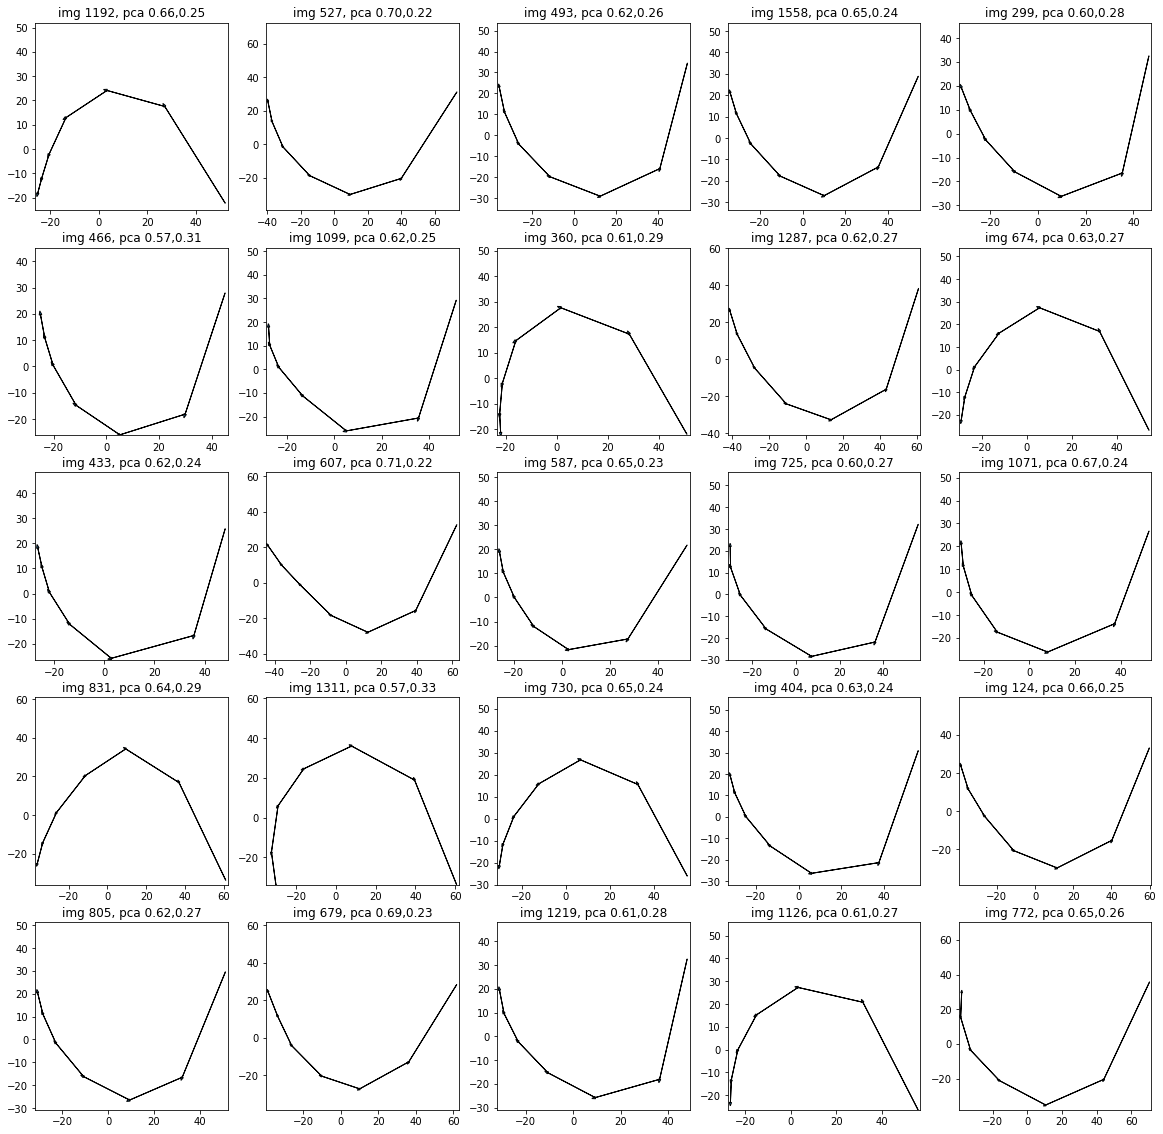

In [39]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 2)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 2, False)

diff_overall                [0.3057136833667755, 0.12170953303575516, 0.08...
diff_per_image_mean         [0.30889623071998357, 0.12357169829774647, 0.0...
diff_per_image_std          [0.06607370840037015, 0.015899928588675123, 0....
corr_test                                                            0.336186
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.112916
mean_diff_per_image                                                  0.114123
mean_diff_overall_first4                                             0.143709
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


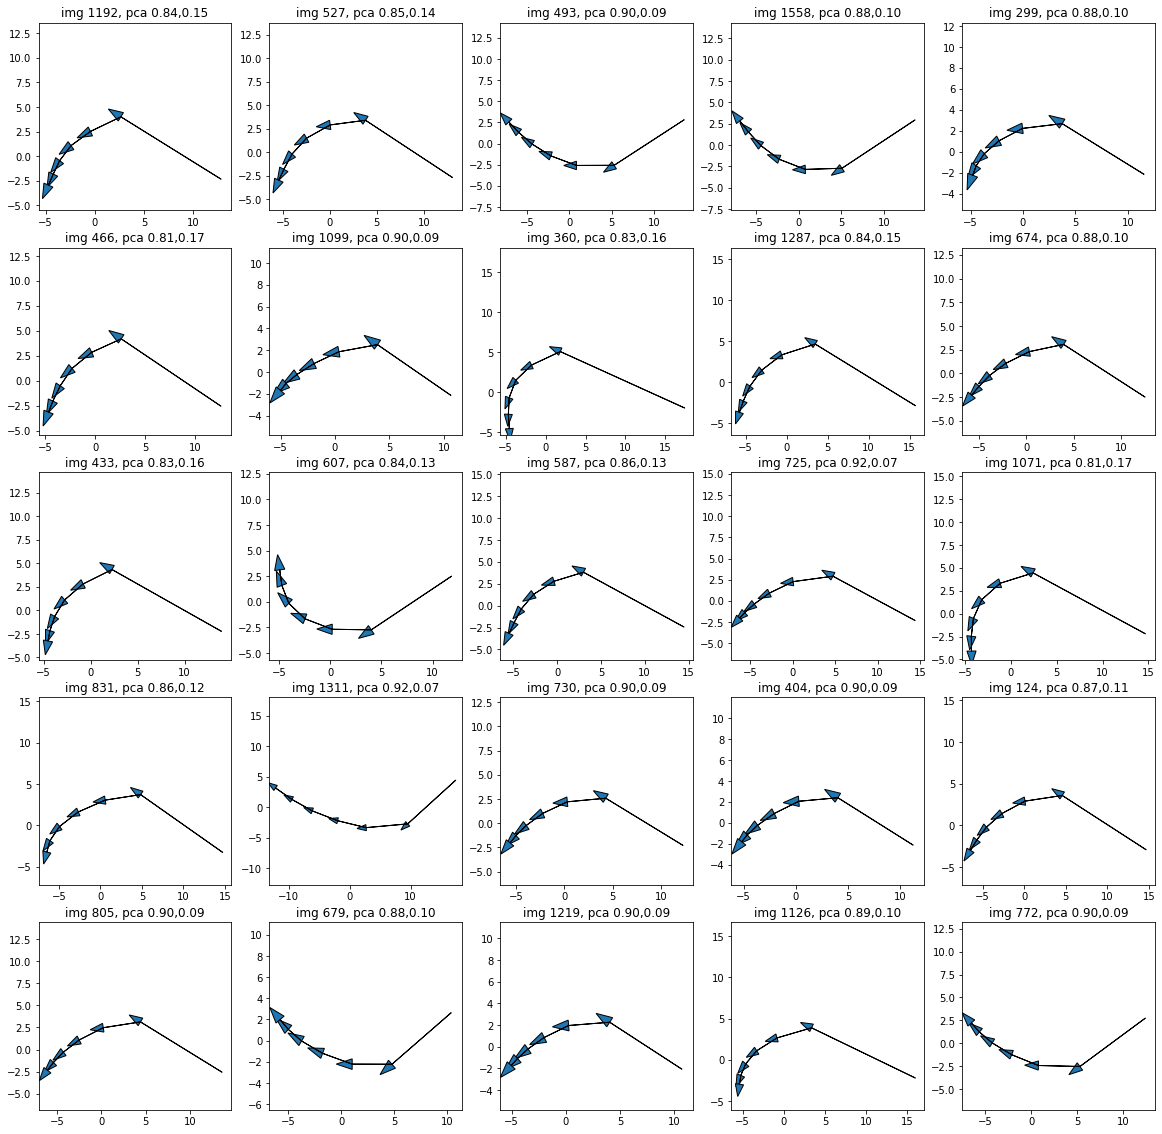

diff_overall                [0.3057136833667755, 0.12170953303575516, 0.08...
diff_per_image_mean         [0.30889623071998357, 0.12357169829774647, 0.0...
diff_per_image_std          [0.06607370840037015, 0.015899928588675123, 0....
corr_test                                                            0.336186
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.112916
mean_diff_per_image                                                  0.114123
mean_diff_overall_first4                                             0.143709
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


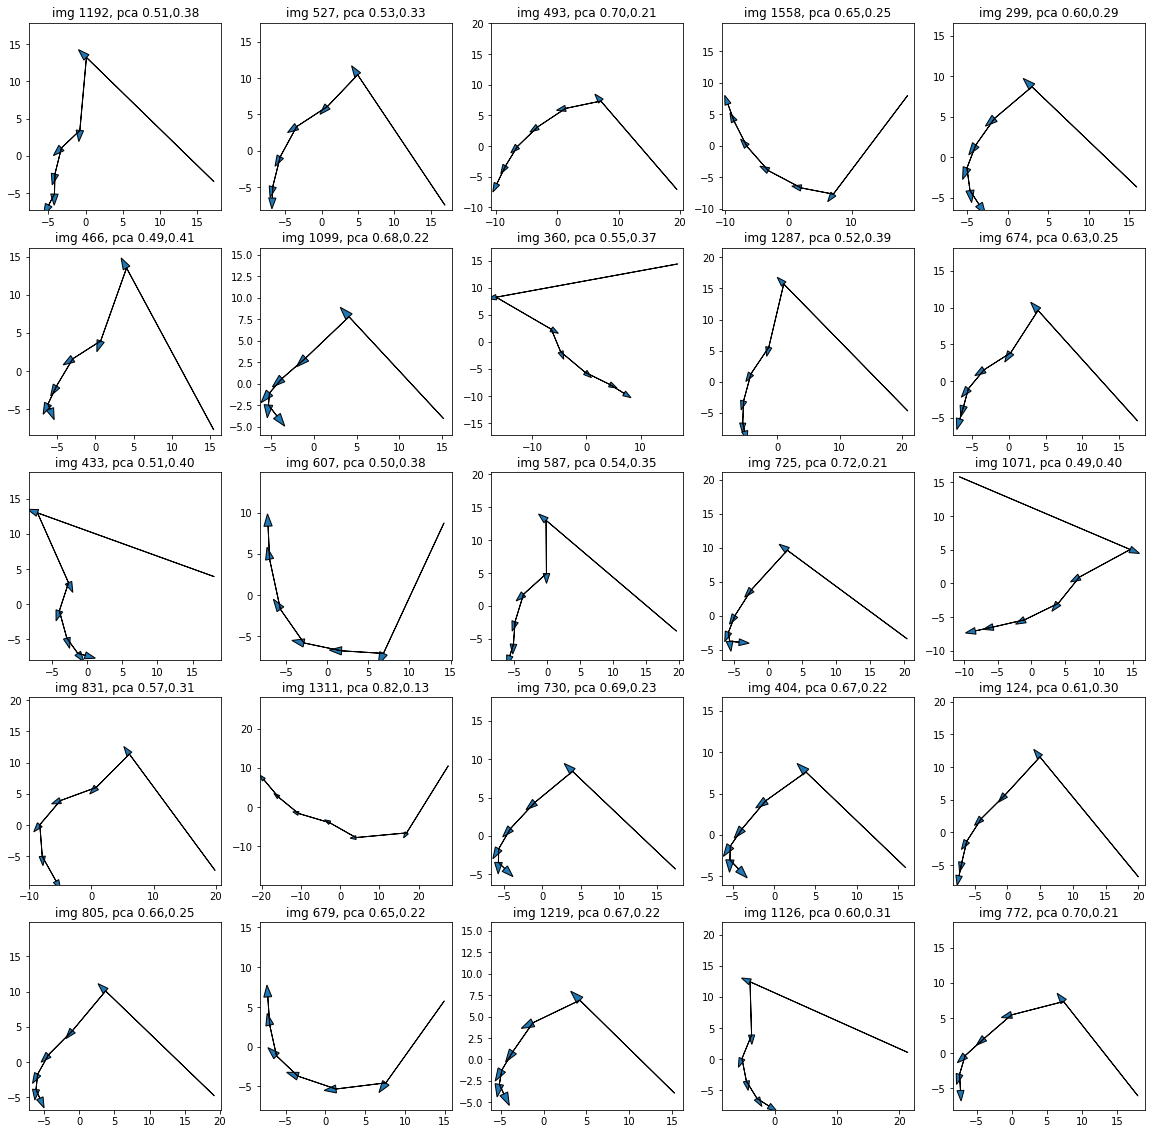

In [40]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 2)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 2, False)

diff_overall                [0.3057136833667755, 0.12170953303575516, 0.08...
diff_per_image_mean         [0.30889623071998357, 0.12357169829774647, 0.0...
diff_per_image_std          [0.06607370840037015, 0.015899928588675123, 0....
corr_test                                                            0.336186
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.112916
mean_diff_per_image                                                  0.114123
mean_diff_overall_first4                                             0.143709
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


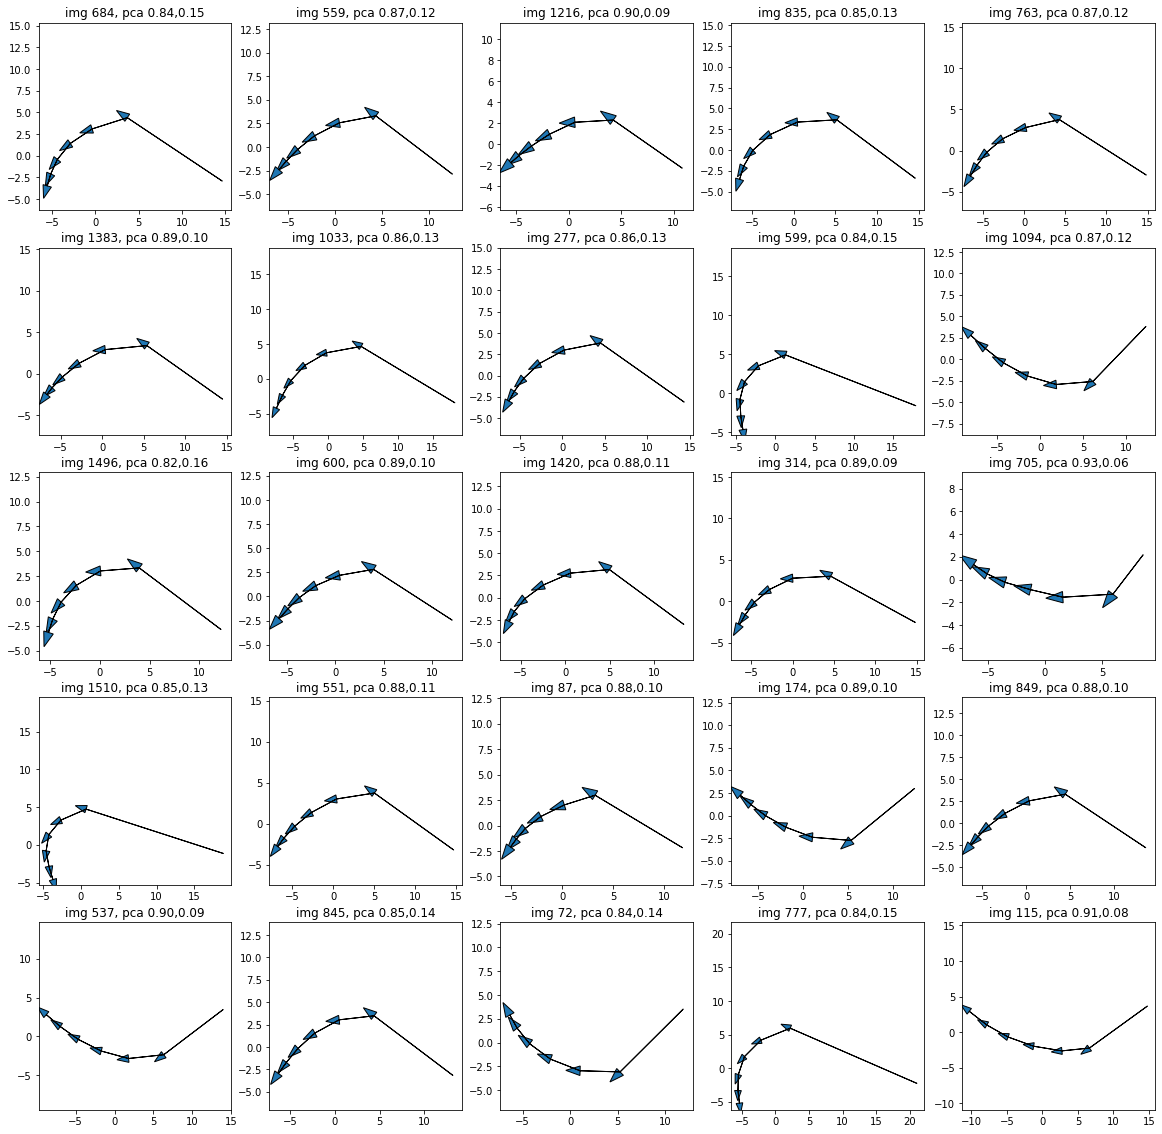

diff_overall                [0.3057136833667755, 0.12170953303575516, 0.08...
diff_per_image_mean         [0.30889623071998357, 0.12357169829774647, 0.0...
diff_per_image_std          [0.06607370840037015, 0.015899928588675123, 0....
corr_test                                                            0.336186
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.112916
mean_diff_per_image                                                  0.114123
mean_diff_overall_first4                                             0.143709
Name: (1280, relu, poisson, 0.01, 5e-06, 2, 8, False), dtype: object


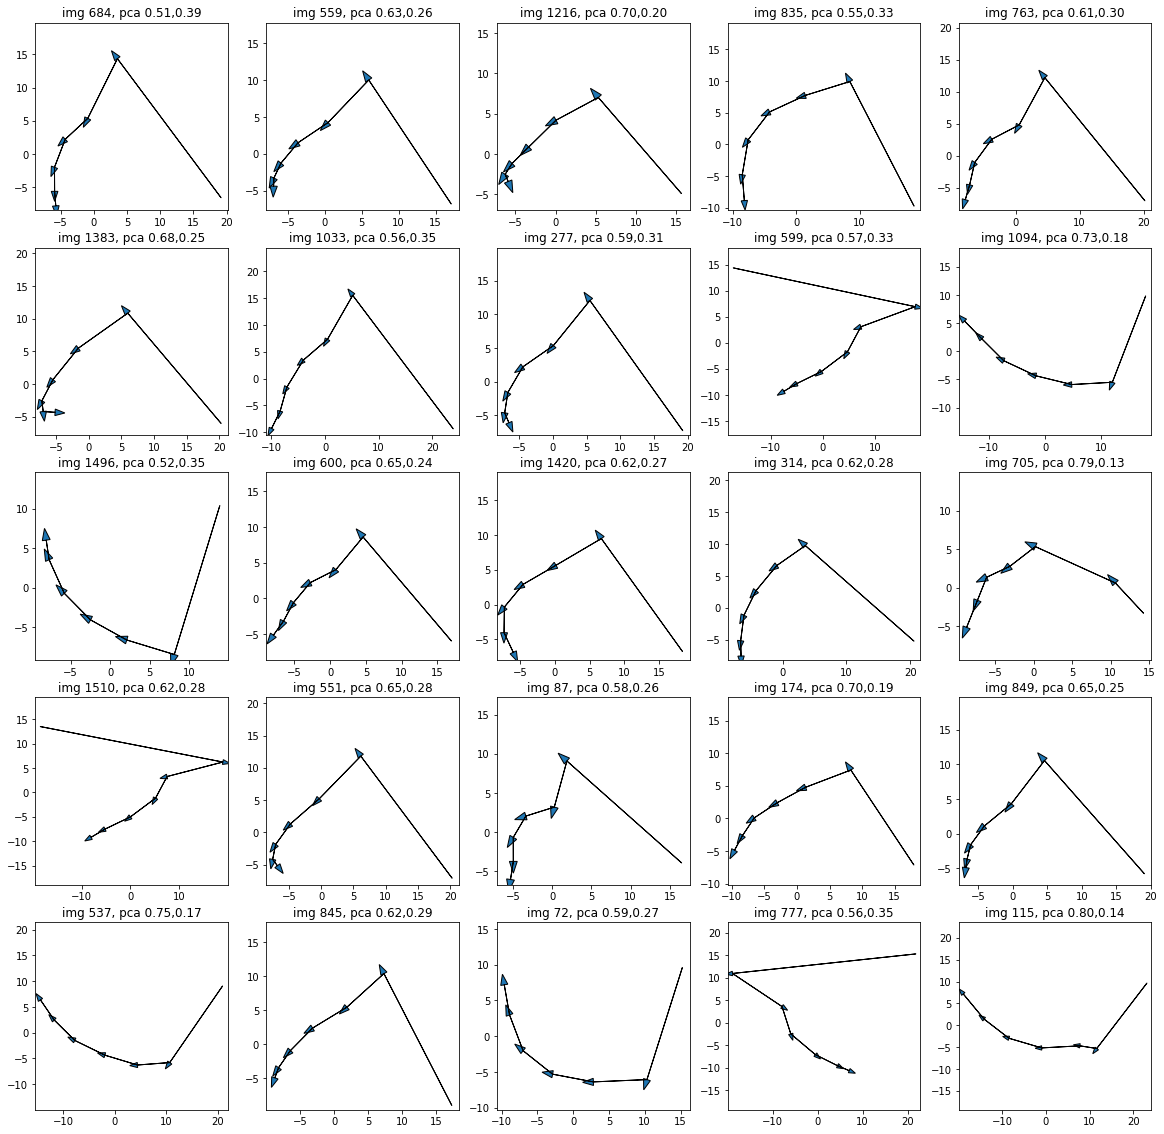

In [41]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 0)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 0, False)

diff_overall                [0.2946435511112213, 0.1453527957201004, 0.094...
diff_per_image_mean         [0.29510270949453116, 0.1474084028787911, 0.09...
diff_per_image_std          [0.040179381233110996, 0.02076539304614358, 0....
corr_test                                                            0.352485
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.122138
mean_diff_per_image                                                  0.122875
mean_diff_overall_first4                                             0.152834
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, False), dtype: object


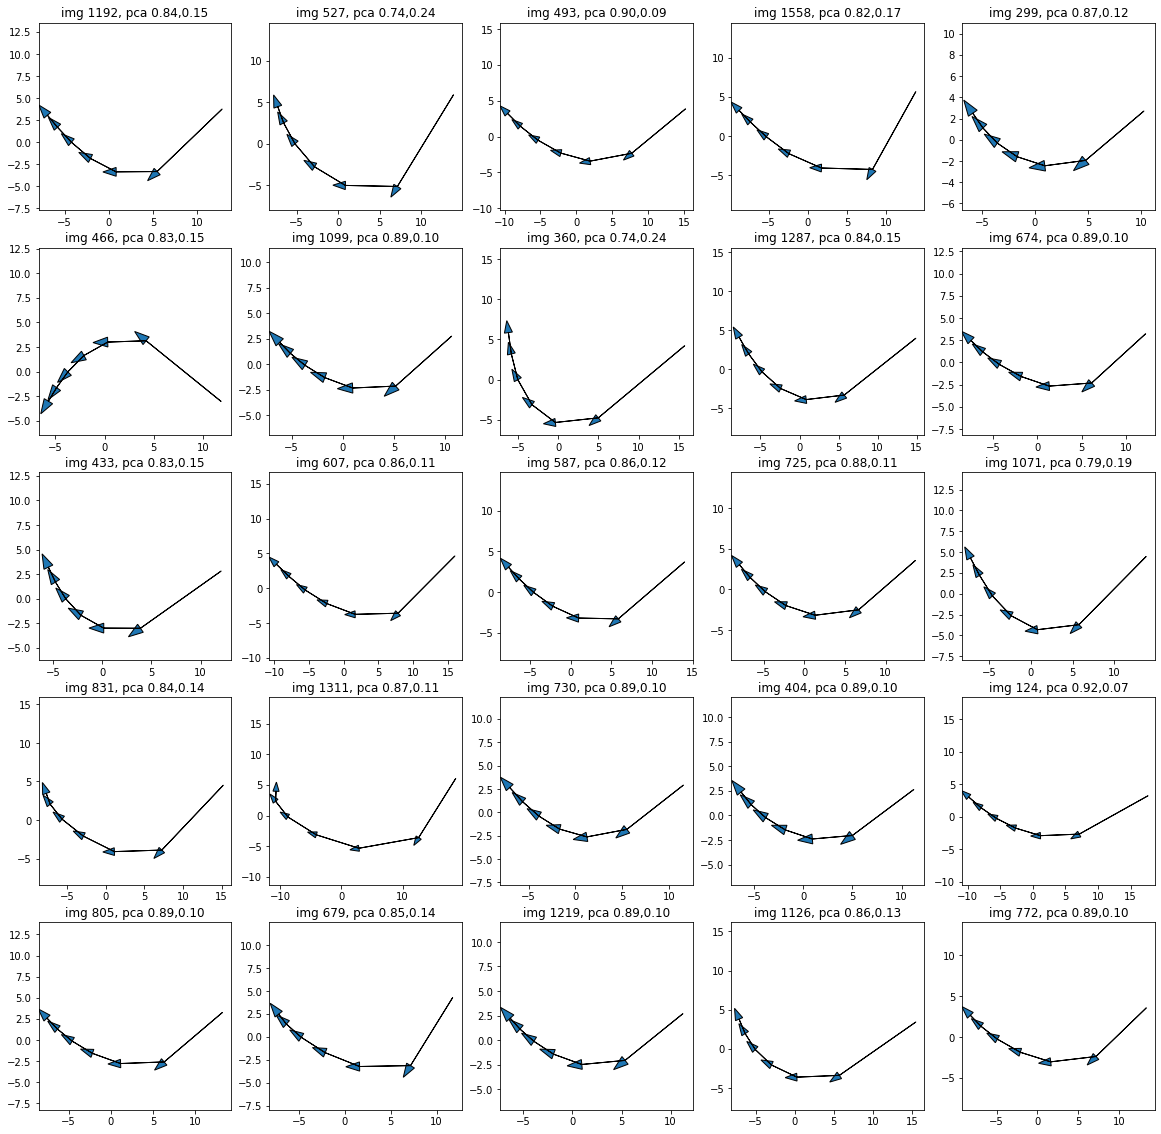

diff_overall                [0.2946435511112213, 0.1453527957201004, 0.094...
diff_per_image_mean         [0.29510270949453116, 0.1474084028787911, 0.09...
diff_per_image_std          [0.040179381233110996, 0.02076539304614358, 0....
corr_test                                                            0.352485
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.122138
mean_diff_per_image                                                  0.122875
mean_diff_overall_first4                                             0.152834
Name: (1280, relu, mse, 0.01, 5e-06, 2, 8, False), dtype: object


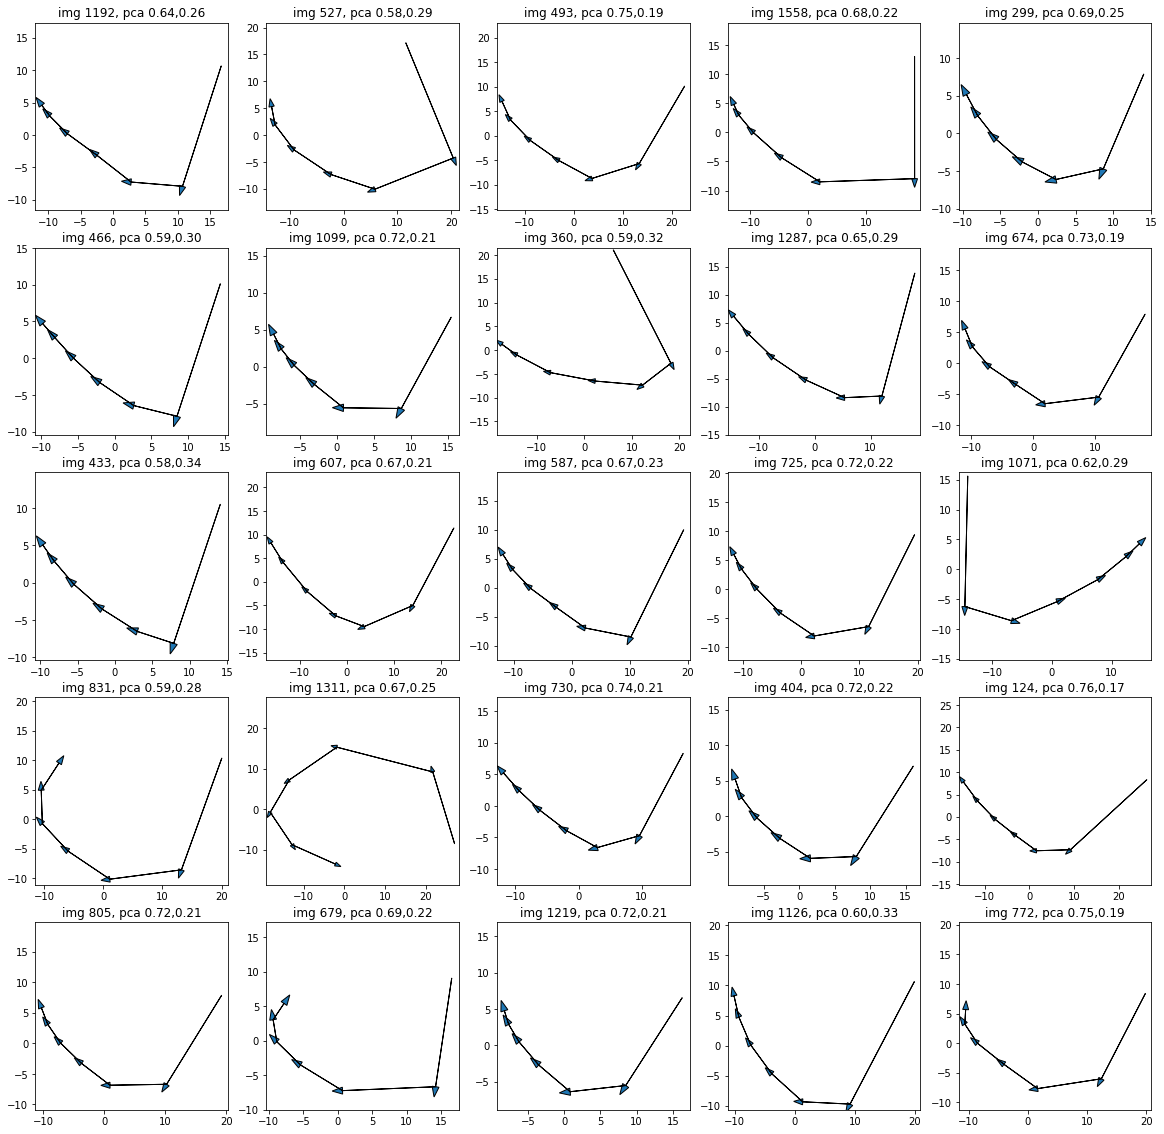

In [42]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-2], 2)
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-2], 2, False)

In [35]:
# this does not work.
# then let's plot things 

def plot_one_graph_given_2d_embedding_list(embedding_list, seed):
    cls = 7
    num_img = 30
    assert len(embedding_list) == cls
    for zzz in embedding_list:
        assert zzz.shape == (1600, 2)
    # randomly take some images out of 1600
    rng_state = np.random.RandomState(seed=seed)
    # take 20 images
    images_to_take =  rng_state.choice(1600, num_img)
    embedding_list = [x[images_to_take] for x in embedding_list]
    for zzzz in embedding_list:
        assert zzzz.shape == (num_img, 2)
    
    
    
    # then plot.
    # plot arrow, one diff at a time
    plt.close('all')
    plt.figure(figsize=(16, 16), dpi=300)
    
    
    for idx_cls in range(cls-1):
        xy = embedding_list[idx_cls]
        xydelta = embedding_list[idx_cls+1]-embedding_list[idx_cls]
        assert xy.shape == xydelta.shape == (num_img, 2)
        for img_idx, (xy_this, xydelta_this) in enumerate(zip(xy, xydelta)):
#             print(xy_this, xydelta_this)
            assert xy_this.shape == xydelta_this.shape == (2,)
            color = colors_to_use[img_idx%len(colors_to_use)]
            plt.arrow(*xy_this, *xydelta_this, color=color)
    
    plt.xlim(min([x[:,0].min() for x in embedding_list]), max([x[:,0].max() for x in embedding_list]))
    plt.ylim(min([x[:,1].min() for x in embedding_list]), max([x[:,1].max() for x in embedding_list]))
    
#     plt.xlim(70, 75)
#     plt.ylim(5, 7.5)

#     plt.xlim(5, 6)
#     plt.ylim(-8, -7)
    
    plt.axis('equal')
    plt.show()

In [36]:
# plot_one_graph_given_2d_embedding_list([data_tsne[idx*1600:(idx+1)*1600] for idx in range(7)], 1)

NameError: name 'data_tsne' is not defined